In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import pandas as pd
import dynamo as dyn

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphvelo.graph_velocity import GraphVelo
from graphvelo.plot import gene_trend, cbc_heatmap, polar_plot

In [4]:
cmap = {'G1-S':'firebrick', 'S':'orange', 'G2-M':'yellowgreen', 'M':'teal', 'M-G1':'royalblue'}

In [5]:
adata = dyn.read("adata_cell_cycle.h5ad")
adata

AnnData object with n_obs × n_vars = 7404 × 543
    obs: 'all_exon', 'all_intron', 'all_reads', 'treatment_time', 'doublet_score', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'sc_phase', 'dyn_phase'
    var: 'gene_type', 'gene_short_name', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'LOGINFO', 'PCs', 'X_V_for_encoder', 'check_x_dim', 'dyn_phase_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_umap', 'neighbors', 'pca_input', 'pca_mean', 'pp', 'sc_phase_colors', 'trea

In [6]:
phase = pd.read_csv('A549_PCA_Phase.csv', index_col=0)
adata.obs['phase'] = phase.values

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering dyn_phase by stack threshold when stacking color because it is not a numeric type


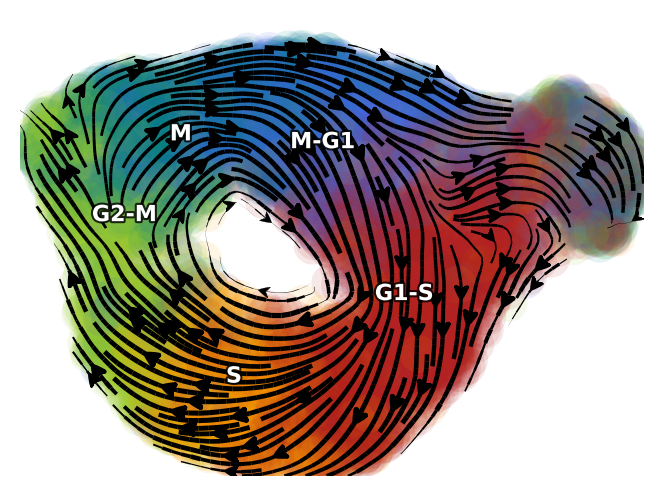

In [7]:
ax = dyn.pl.streamline_plot(adata, color=['dyn_phase'], color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/A549_cc_vf.svg', bbox_inches = "tight")
plt.show()

In [5]:
gv = GraphVelo(adata, gene_subset=adata[:, adata.var['use_for_transition']].var_names, xkey='M_t', vkey='velocity_T')
gv.train()
adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['M_t'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])

Learning Phi in tangent space projection.: 100%|██████████| 7404/7404 [00:07<00:00, 942.53it/s] 
projecting velocity vector to low dimensional embedding: 100%|██████████| 7404/7404 [00:01<00:00, 6370.16it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 7404/7404 [00:00<00:00, 13014.39it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 7404/7404 [00:00<00:00, 15097.52it/s]


|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering dyn_phase by stack threshold when stacking color because it is not a numeric type


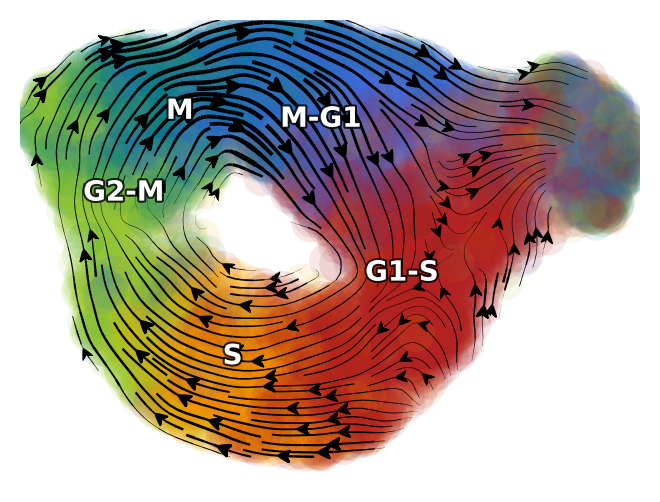

In [92]:
ax = dyn.pl.streamline_plot(adata, color=['dyn_phase'], vector='gv', color_key=cmap, save_show_or_return='return', figsize=(4,3))
plt.title('')
plt.savefig(dpi=300, transparent=True, fname=f'./figures/A549_cc_gv_vf.svg', bbox_inches = "tight")
plt.show()

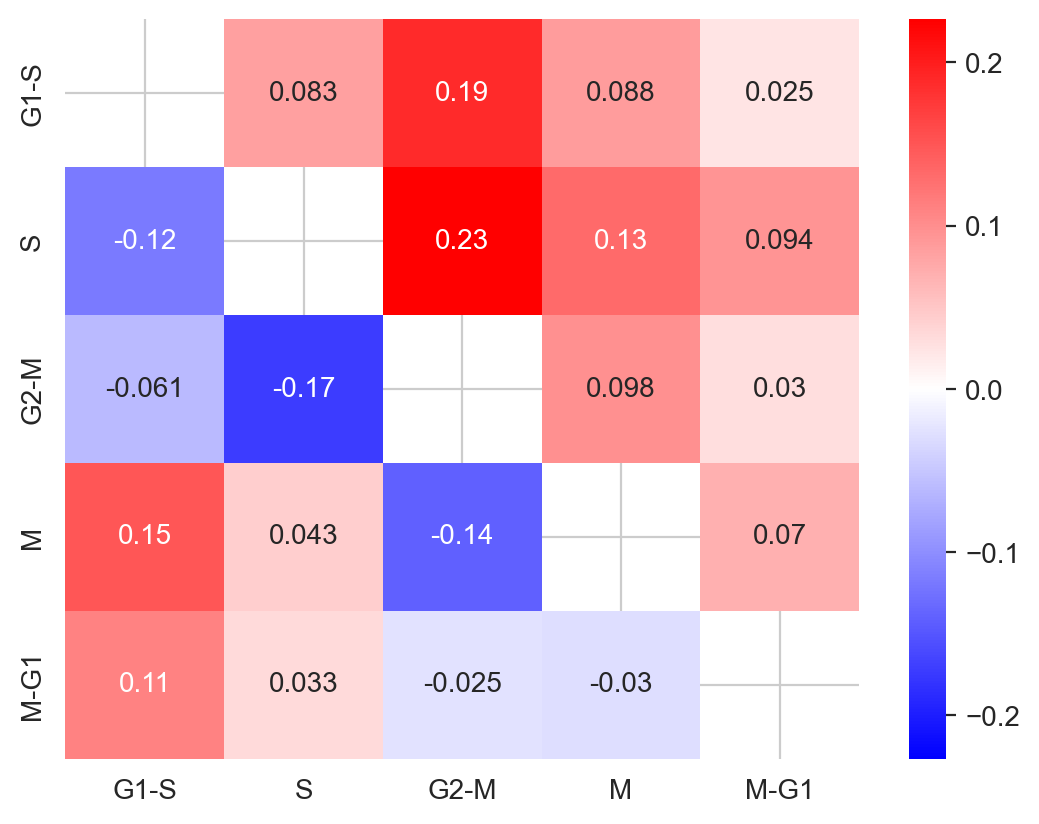

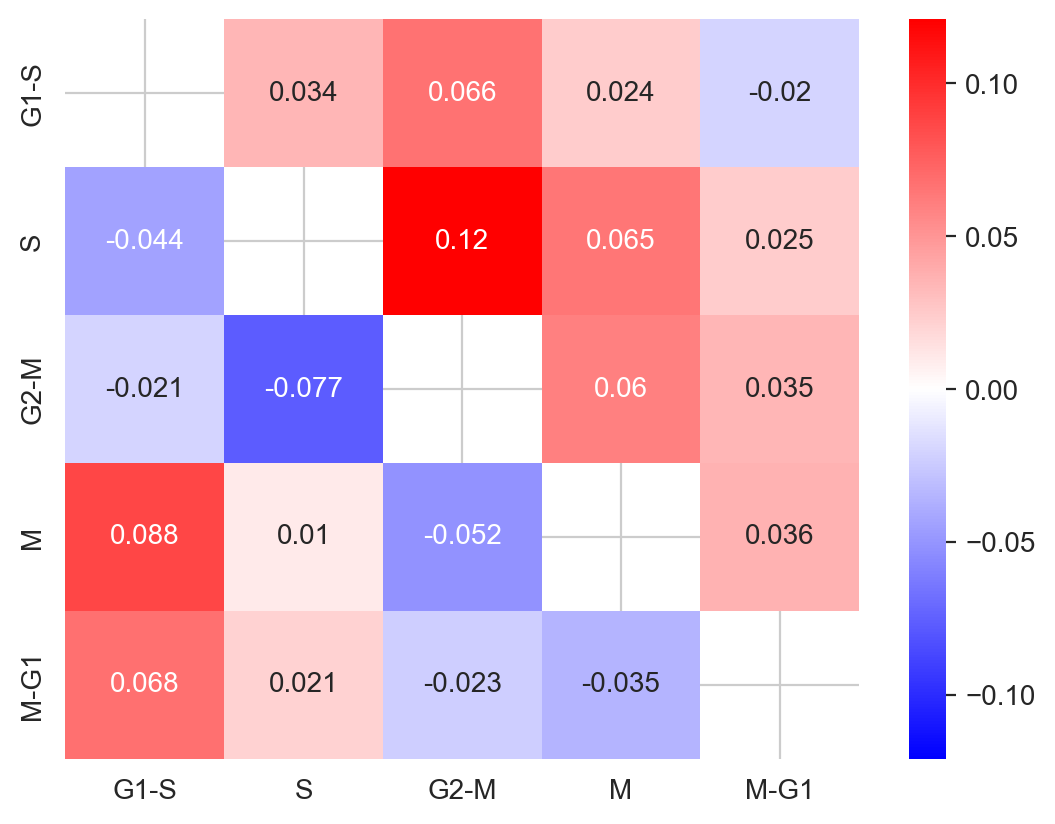

In [79]:
cbc_heatmap(adata, xkey='M_t', vkey='velocity_gv', cluster_key='dyn_phase', basis='raw', vector='gv', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.savefig(dpi=300, transparent=True, fname=f'./figures/gv_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()
cbc_heatmap(adata, xkey='M_t', vkey='velocity_T', cluster_key='dyn_phase', basis='raw', custom_order=['G1-S', 'S', 'G2-M', 'M', 'M-G1'])
plt.savefig(dpi=300, transparent=True, fname=f'./figures/dyn_cbcheatmap.pdf', bbox_inches = "tight")
plt.show()

## Cell speed analysis

In [9]:
adata.obs['speed_gv'] = np.linalg.norm(adata.layers['velocity_gv'].A, axis=1)
velo = adata.layers['velocity_T'].A
velo[np.isnan(velo)] = 0
adata.obs['speed'] = np.linalg.norm(velo, axis=1)

|-----------> plotting with basis key=X_umap


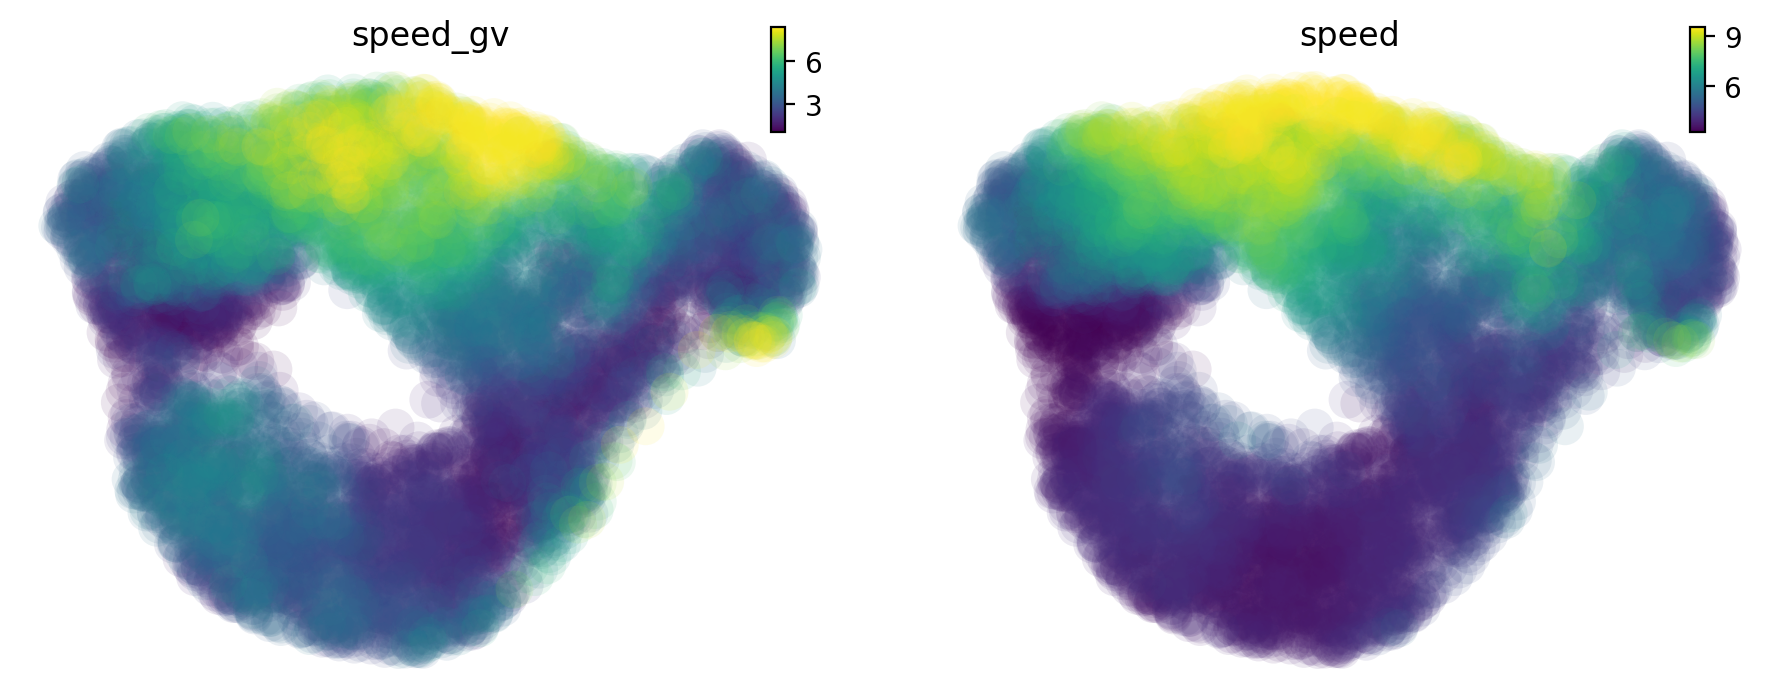

In [10]:
dyn.pl.scatters(adata, color=['speed_gv', 'speed'])

In [11]:
from pygam import LinearGAM, s

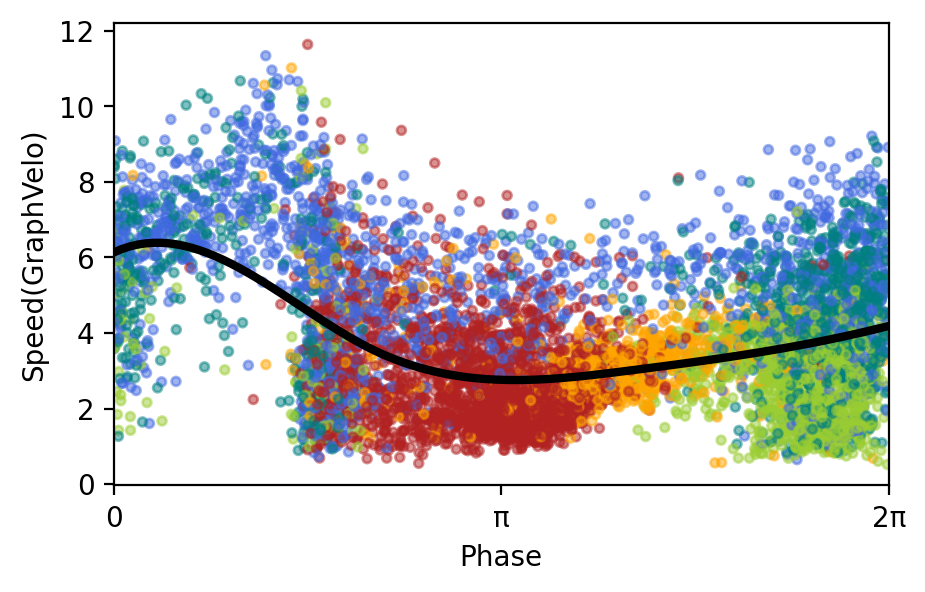

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
x, y = adata.obs['phase'].values, adata.obs['speed_gv'].values
term = s(0, n_splines=6, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata.obs['dyn_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, color='black', linewidth=3)
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("Phase")
plt.ylabel("Speed(GraphVelo)")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/a549_speed_trend.pdf', bbox_inches = "tight")
plt.show()

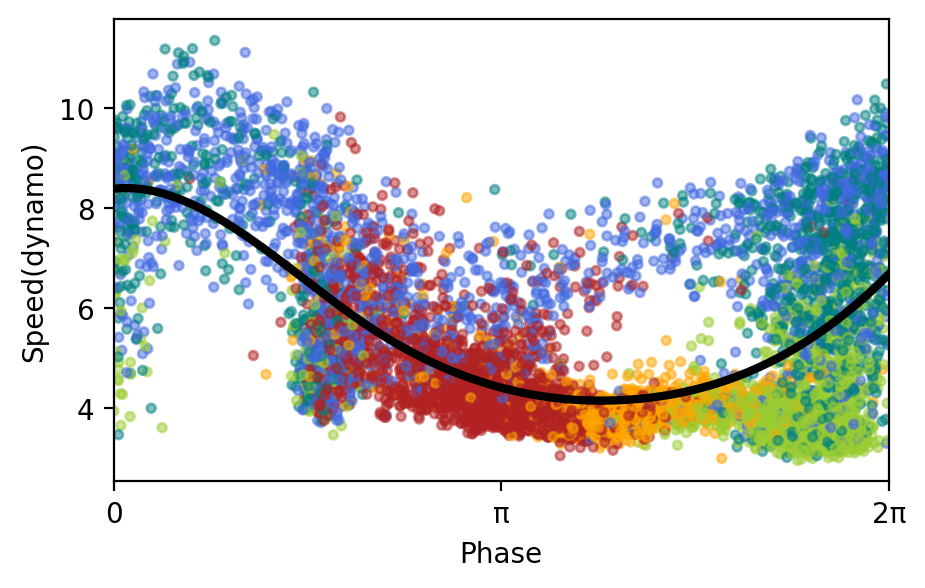

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
x, y = adata.obs['phase'].values, adata.obs['speed'].values
term = s(0, n_splines=6, spline_order=3)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata.obs['dyn_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, color='black', linewidth=3)
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("Phase")
plt.ylabel("Speed(dynamo)")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/a549_speed_trend_dyn.pdf', bbox_inches = "tight")
plt.show()

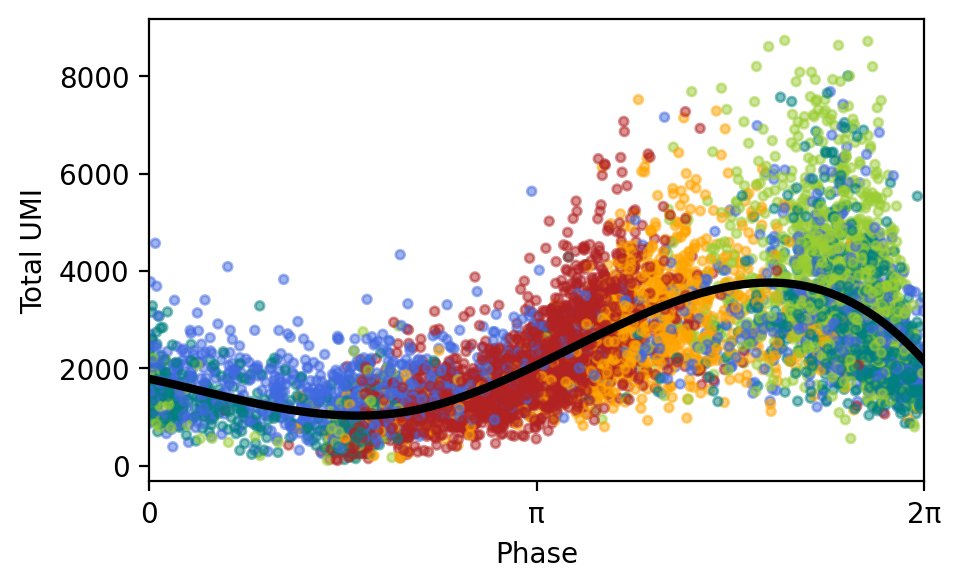

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,3))
x, y = adata.obs['phase'].values, adata.layers['total'].A.sum(1)
term = s(0, n_splines=6, spline_order=3,)
gam = LinearGAM(term, max_iter=2000, verbose=False).fit(x, y)
x_lins = np.linspace(x.min(), x.max(), 100)
y_pred = gam.predict(x_lins)
plt.scatter(x, y, c=adata.obs['dyn_phase'].map(cmap), s=10, alpha=0.5)
plt.plot(x_lins, y_pred, color='black', linewidth=3)
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("Phase")
plt.ylabel("Total UMI")
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/a549_umi_trend.pdf', bbox_inches = "tight")
plt.show()

Identify velocity peaks using GAM: 100%|██████████| 554/554 [00:16<00:00, 33.81it/s]


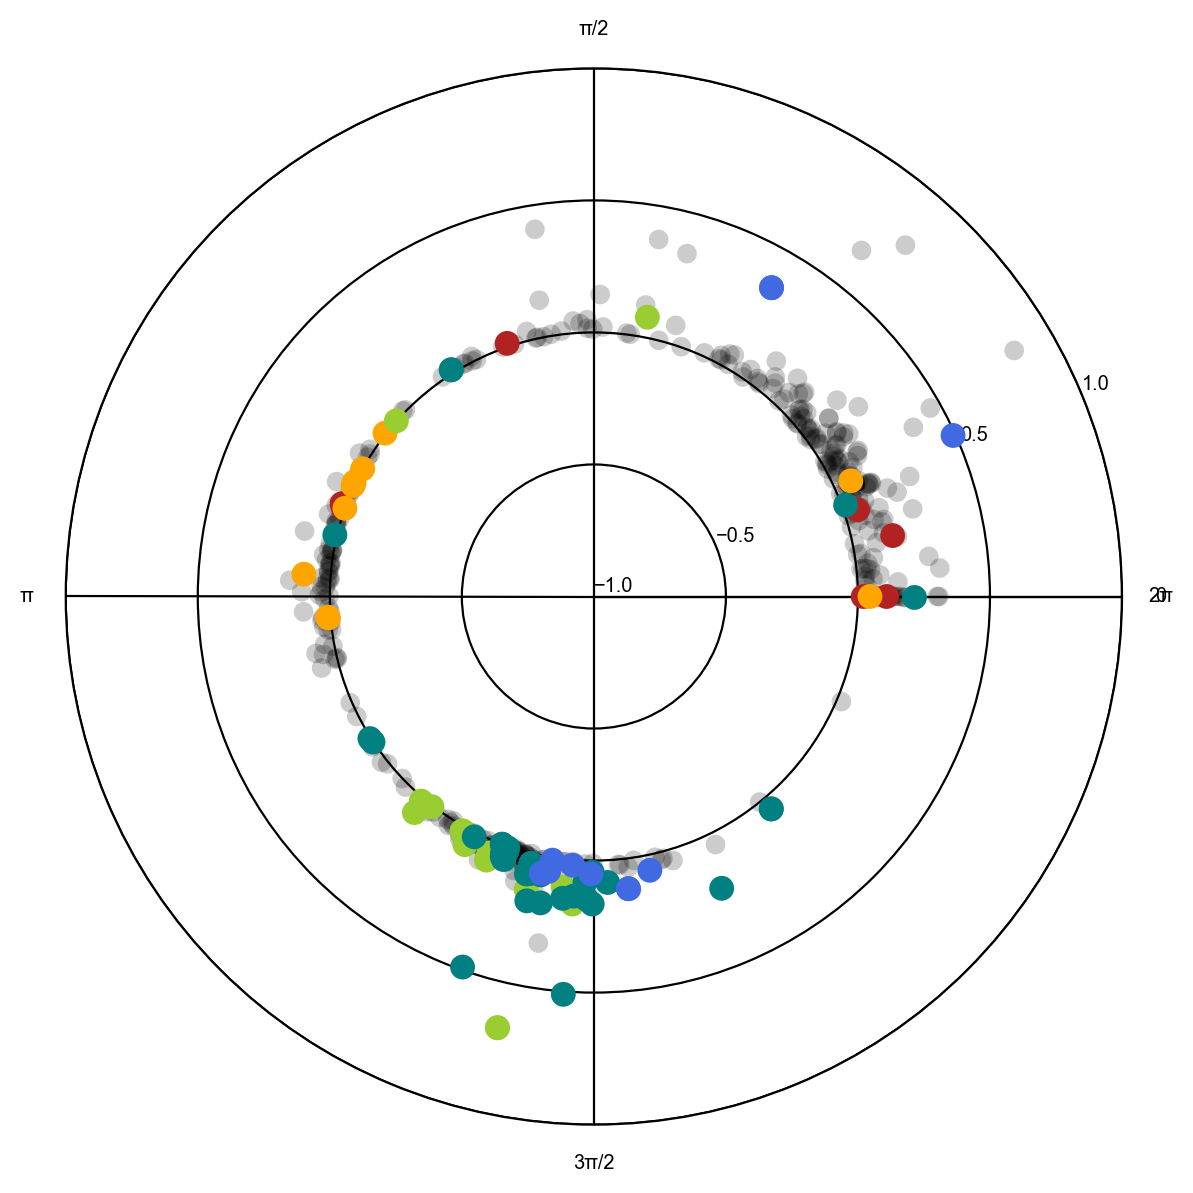

In [9]:
ax = polar_plot(adata, phase_key='phase', show_markers=False, show=False)
# plt.savefig(dpi=300, transparent=True, fname=f'./figures/a549_polar.pdf', bbox_inches = "tight")
plt.show()